<a href="https://colab.research.google.com/github/Namgyo/IE55201-Final-Project-20245039/blob/main/Applied_Experiment_Reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Define a high-dimensional, highly non-linear dataset
class HighDimComplexDataset(Dataset):
    """
    High-dimensional complex dataset.
    Points are sampled in high-dimensional space and transformed via a non-linear, augmented mapping.
    """
    def __init__(self, num_points=3000, dim=20, noise=0.2):
        self.data = []
        self.labels = []
        for _ in range(num_points):
            # Generate a random high-dimensional point
            point = np.random.uniform(-1, 1, dim)

            # Complex non-linear label assignment using trigonometric functions
            label = 1 if np.sin(np.sum(point[:dim//2])) + np.cos(np.sum(point[dim//2:])) > 0 else 0

            # Add Gaussian noise
            point += np.random.normal(0, noise, dim)

            self.data.append(point)
            self.labels.append(label)
        self.data = torch.Tensor(self.data)
        self.labels = torch.Tensor(self.labels).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [35]:
# Define the Neural ODE model
class NeuralODE(nn.Module):
    """
    Neural ODE model using a standard feedforward architecture.
    """
    def __init__(self, input_dim):
        super(NeuralODE, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.model(x)

In [36]:
# Define the Augmented Neural ODE model
class AugmentedNeuralODE(nn.Module):
    """
    Augmented Neural ODE model with additional dimensions and a deeper network.
    """
    def __init__(self, input_dim):
        super(AugmentedNeuralODE, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 3, 256),  # Input + 3 augmented dimensions
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        # Augment input with additional non-linear features
        sin_feature = torch.sin(x.sum(dim=1, keepdim=True))  # Sine of sum
        cos_feature = torch.cos(x.sum(dim=1, keepdim=True))  # Cosine of sum
        constant_feature = torch.ones((x.shape[0], 1))       # Constant dimension
        x = torch.cat([x, sin_feature, cos_feature, constant_feature], dim=1)
        return self.model(x)

In [37]:
# Prepare the dataset and loaders
input_dim = 20  # High-dimensional input space
train_dataset = HighDimComplexDataset(num_points=3000, dim=input_dim, noise=0.2)
test_dataset = HighDimComplexDataset(num_points=1000, dim=input_dim, noise=0.2)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [38]:
# Initialize models
neural_ode = NeuralODE(input_dim=input_dim)
augmented_neural_ode = AugmentedNeuralODE(input_dim=input_dim)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_node = torch.optim.Adam(neural_ode.parameters(), lr=0.001)
optimizer_anode = torch.optim.Adam(augmented_neural_ode.parameters(), lr=0.001)

In [39]:
# Training loop
def train_model(model, optimizer, loader, epochs=30):
    """
    Train a given model on the provided data loader.
    """
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for data, labels in loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_history.append(total_loss / len(loader))
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}")
    return loss_history

In [40]:
# Train both models
print("Training Neural ODE...")
loss_node = train_model(neural_ode, optimizer_node, train_loader)

print("\nTraining Augmented Neural ODE...")
loss_anode = train_model(augmented_neural_ode, optimizer_anode, train_loader)

Training Neural ODE...
Epoch 1/30, Loss: 0.6638
Epoch 2/30, Loss: 0.6275
Epoch 3/30, Loss: 0.5966
Epoch 4/30, Loss: 0.5502
Epoch 5/30, Loss: 0.5161
Epoch 6/30, Loss: 0.4946
Epoch 7/30, Loss: 0.4673
Epoch 8/30, Loss: 0.4409
Epoch 9/30, Loss: 0.4135
Epoch 10/30, Loss: 0.3847
Epoch 11/30, Loss: 0.3603
Epoch 12/30, Loss: 0.3423
Epoch 13/30, Loss: 0.3247
Epoch 14/30, Loss: 0.3152
Epoch 15/30, Loss: 0.2989
Epoch 16/30, Loss: 0.2857
Epoch 17/30, Loss: 0.2736
Epoch 18/30, Loss: 0.2651
Epoch 19/30, Loss: 0.2633
Epoch 20/30, Loss: 0.2408
Epoch 21/30, Loss: 0.2264
Epoch 22/30, Loss: 0.2232
Epoch 23/30, Loss: 0.2118
Epoch 24/30, Loss: 0.2028
Epoch 25/30, Loss: 0.1918
Epoch 26/30, Loss: 0.1832
Epoch 27/30, Loss: 0.1793
Epoch 28/30, Loss: 0.1623
Epoch 29/30, Loss: 0.1521
Epoch 30/30, Loss: 0.1482

Training Augmented Neural ODE...
Epoch 1/30, Loss: 0.6449
Epoch 2/30, Loss: 0.5780
Epoch 3/30, Loss: 0.4967
Epoch 4/30, Loss: 0.4562
Epoch 5/30, Loss: 0.4203
Epoch 6/30, Loss: 0.3909
Epoch 7/30, Loss: 0.35

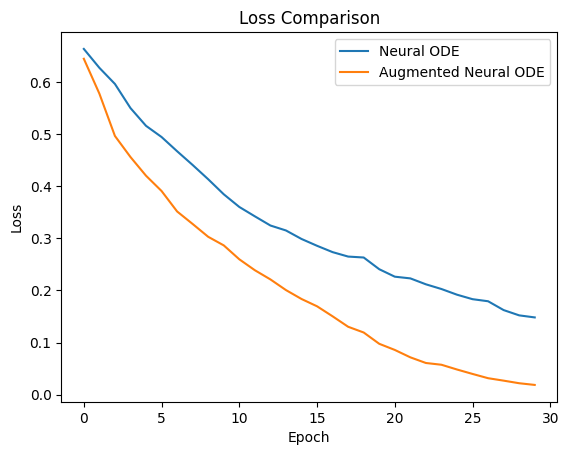

In [41]:
# Plot loss curves
plt.plot(loss_node, label="Neural ODE")
plt.plot(loss_anode, label="Augmented Neural ODE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

In [42]:
# Evaluate the models
def evaluate_model(model, loader):
    """
    Evaluate a model's accuracy on the given data loader.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [43]:
# Measure accuracy
accuracy_node = evaluate_model(neural_ode, test_loader)
accuracy_anode = evaluate_model(augmented_neural_ode, test_loader)

print(f"Neural ODE Accuracy: {accuracy_node:.2%}")
print(f"Augmented Neural ODE Accuracy: {accuracy_anode:.2%}")

Neural ODE Accuracy: 74.90%
Augmented Neural ODE Accuracy: 75.20%


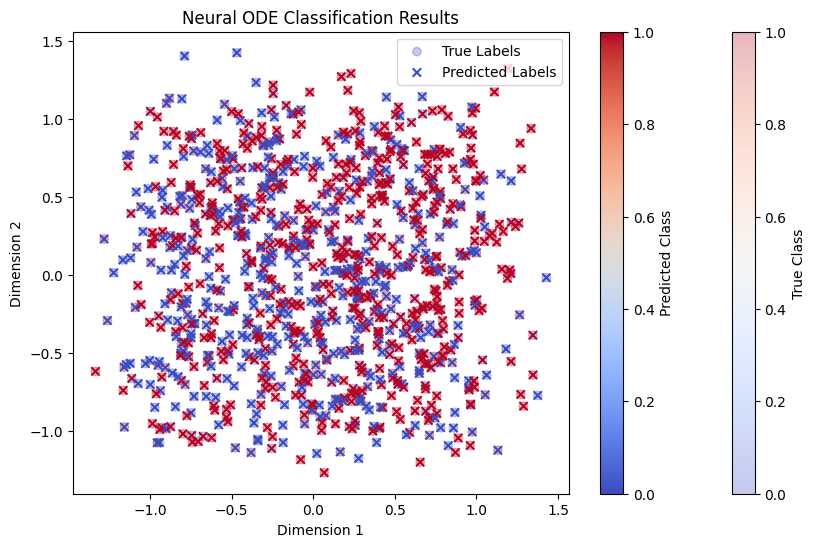

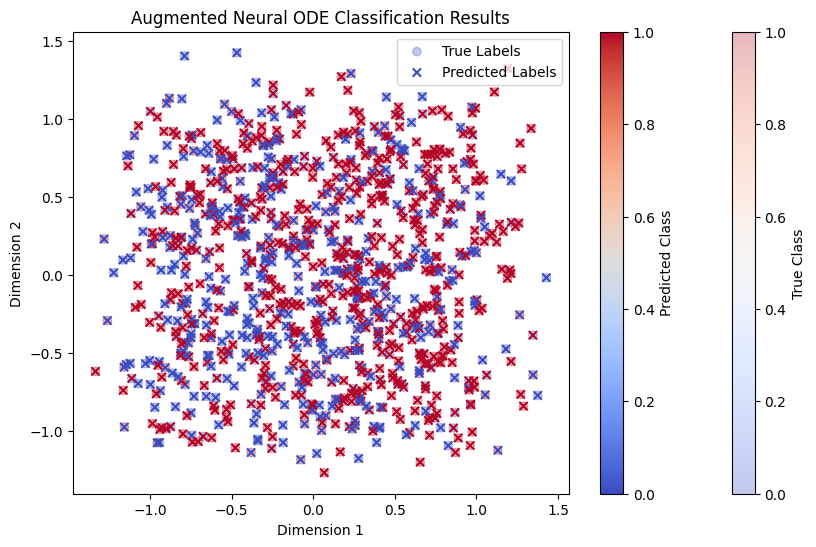

In [44]:
# Function to visualize classification results in 2D
def plot_classification_results(model, dataset, title, dim1=0, dim2=1):
    """
    Visualize classification results by projecting high-dimensional data to 2D.

    Parameters:
        model (nn.Module): Trained model (Neural ODE or Augmented Neural ODE).
        dataset (Dataset): Dataset to evaluate.
        title (str): Title for the plot.
        dim1 (int): Index of the first dimension to project onto.
        dim2 (int): Index of the second dimension to project onto.
    """
    model.eval()
    data = dataset.data.numpy()
    labels = dataset.labels.numpy()

    # Project high-dimensional data onto specified 2D plane
    x1 = data[:, dim1]
    x2 = data[:, dim2]

    # Predict labels
    with torch.no_grad():
        predictions = model(torch.Tensor(data))
        predicted_labels = predictions.argmax(dim=1).numpy()

    # Plot the true labels
    plt.figure(figsize=(10, 6))
    plt.scatter(x1, x2, c=labels, cmap="coolwarm", alpha=0.3, label="True Labels")
    plt.colorbar(label="True Class")

    # Overlay predicted labels
    plt.scatter(x1, x2, c=predicted_labels, cmap="coolwarm", marker="x", label="Predicted Labels")
    plt.colorbar(label="Predicted Class")
    plt.title(title)
    plt.xlabel(f"Dimension {dim1 + 1}")
    plt.ylabel(f"Dimension {dim2 + 1}")
    plt.legend()
    plt.show()

# Visualize Neural ODE classification results
plot_classification_results(neural_ode, test_dataset, "Neural ODE Classification Results")

# Visualize Augmented Neural ODE classification results
plot_classification_results(augmented_neural_ode, test_dataset, "Augmented Neural ODE Classification Results")


In [45]:
from sklearn.metrics import classification_report, confusion_matrix

# Function to evaluate model performance numerically
def evaluate_classification_metrics(model, loader):
    """
    Evaluate a model using accuracy, precision, recall, and F1-score.

    Parameters:
        model (nn.Module): The trained model to evaluate.
        loader (DataLoader): DataLoader containing the test dataset.

    Returns:
        dict: A dictionary containing classification metrics.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    metrics = classification_report(all_labels, all_predictions, output_dict=True)
    confusion = confusion_matrix(all_labels, all_predictions)
    return metrics, confusion

# Evaluate Neural ODE
print("Evaluating Neural ODE...")
metrics_node, confusion_node = evaluate_classification_metrics(neural_ode, test_loader)

# Evaluate Augmented Neural ODE
print("\nEvaluating Augmented Neural ODE...")
metrics_anode, confusion_anode = evaluate_classification_metrics(augmented_neural_ode, test_loader)

# Display results
def display_results(metrics, confusion, model_name):
    """
    Print classification metrics and confusion matrix.

    Parameters:
        metrics (dict): Dictionary containing precision, recall, F1-score, etc.
        confusion (ndarray): Confusion matrix.
        model_name (str): Name of the model (e.g., Neural ODE or Augmented Neural ODE).
    """
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision (Class 0): {metrics['0']['precision']:.4f}")
    print(f"Recall (Class 0): {metrics['0']['recall']:.4f}")
    print(f"F1-Score (Class 0): {metrics['0']['f1-score']:.4f}")
    print(f"Precision (Class 1): {metrics['1']['precision']:.4f}")
    print(f"Recall (Class 1): {metrics['1']['recall']:.4f}")
    print(f"F1-Score (Class 1): {metrics['1']['f1-score']:.4f}")
    print("\nConfusion Matrix:")
    print(confusion)

# Display results for both models
display_results(metrics_node, confusion_node, "Neural ODE")
display_results(metrics_anode, confusion_anode, "Augmented Neural ODE")

Evaluating Neural ODE...

Evaluating Augmented Neural ODE...

=== Neural ODE ===
Accuracy: 0.7490
Precision (Class 0): 0.6734
Recall (Class 0): 0.7414
F1-Score (Class 0): 0.7057
Precision (Class 1): 0.8101
Recall (Class 1): 0.7542
F1-Score (Class 1): 0.7812

Confusion Matrix:
[[301 105]
 [146 448]]

=== Augmented Neural ODE ===
Accuracy: 0.7520
Precision (Class 0): 0.6955
Recall (Class 0): 0.6921
F1-Score (Class 0): 0.6938
Precision (Class 1): 0.7903
Recall (Class 1): 0.7929
F1-Score (Class 1): 0.7916

Confusion Matrix:
[[281 125]
 [123 471]]
